In [1]:
from matplotlib import pyplot as plt
from time import process_time
import recognizer
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [2]:
data = []
pred_data = []

for root, subdirs, files in os.walk('dataset/xml_logs'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                # if test data label = 10 then data else test_data append
                data.append((label, resampled))

for root, subdirs, files in os.walk('dataset/val_data'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                # if test data label = 10 then data else test_data append
                pred_data.append((label, resampled))

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

In [3]:
#print(test_data[0])
#print(test_data.count('left_sq_bracket'))
print(len(pred_data))
#print(data[0][0])

160


In [4]:
# Prepare the data
labels = [sample[0] for sample in data]
pred_labels = [sample[0] for sample in pred_data]

#print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
pred_labels_encoded = encoder.fit_transform(pred_labels)

#print(set(labels_encoded))

y = to_categorical(labels_encoded)
y_pred_test = to_categorical(pred_labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
pred_seq = [sample[1] for sample in pred_data]
X = np.array(sequences)
X_pred_test = np.array(pred_seq)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_pred_test.shape, X_pred_test.shape)

16
(4096, 50, 2) (1024, 50, 2) (4096, 16) (1024, 16) (160, 16) (160, 50, 2)


In [5]:
def get_model(layers):
    # Define the model
    model = Sequential()
    
    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(layers, input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

model_64 = get_model(64)
model_32 = get_model(32)
model_16 = get_model(16)
model_8 = get_model(8)

In [7]:
# Train the model
history_64 = model_64.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
128/128 [==============================] - 2s 9ms/step - loss: 1.5318 - accuracy: 0.5491 - val_loss: 0.4280 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 7ms/step - loss: 0.2184 - accuracy: 0.9546 - val_loss: 0.1015 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 7ms/step - loss: 0.1031 - accuracy: 0.9751 - val_loss: 0.0933 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0637 - accuracy: 0.9851 - val_loss: 0.0236 - val_accuracy: 0.9941 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0497 - accuracy: 0.9878 - val_loss: 0.0246 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0436 - accuracy: 0.9895 - val_loss: 0.0331 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 7ms/step - lo

In [8]:
history_32 = model_32.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
128/128 [==============================] - 2s 7ms/step - loss: 2.0619 - accuracy: 0.4124 - val_loss: 1.0299 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 5ms/step - loss: 0.5751 - accuracy: 0.8801 - val_loss: 0.2956 - val_accuracy: 0.9316 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 5ms/step - loss: 0.2173 - accuracy: 0.9573 - val_loss: 0.1487 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 5ms/step - loss: 0.1058 - accuracy: 0.9771 - val_loss: 0.0808 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 5ms/step - loss: 0.0800 - accuracy: 0.9817 - val_loss: 0.0508 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 5ms/step - loss: 0.0655 - accuracy: 0.9849 - val_loss: 0.0555 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 5ms/step - lo

In [9]:
history_16 = model_16.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
128/128 [==============================] - 2s 6ms/step - loss: 2.2707 - accuracy: 0.2385 - val_loss: 1.6048 - val_accuracy: 0.4346 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 4ms/step - loss: 1.0950 - accuracy: 0.6992 - val_loss: 0.7546 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 4ms/step - loss: 0.5943 - accuracy: 0.8577 - val_loss: 0.4484 - val_accuracy: 0.9102 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 4ms/step - loss: 0.3422 - accuracy: 0.9294 - val_loss: 0.2550 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 4ms/step - loss: 0.2020 - accuracy: 0.9590 - val_loss: 0.1506 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 4ms/step - loss: 0.1334 - accuracy: 0.9746 - val_loss: 0.1165 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 4ms/step - lo

In [10]:
history_8 = model_8.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
128/128 [==============================] - 2s 6ms/step - loss: 2.4504 - accuracy: 0.2615 - val_loss: 1.9833 - val_accuracy: 0.3857 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 0s 4ms/step - loss: 1.5738 - accuracy: 0.5449 - val_loss: 1.2350 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 0s 4ms/step - loss: 0.9947 - accuracy: 0.7427 - val_loss: 0.8048 - val_accuracy: 0.7930 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.8301 - val_loss: 0.5443 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 0s 4ms/step - loss: 0.4828 - accuracy: 0.8574 - val_loss: 0.4398 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 0s 4ms/step - loss: 0.3967 - accuracy: 0.8665 - val_loss: 0.3644 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 0s 4ms/step - lo

In [11]:
model_64.summary()
model_32.summary()
model_16.summary()
model_8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 19,760
Trainable params: 19,760
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4480      
                                                                 
 dense_2 (Dense)             (

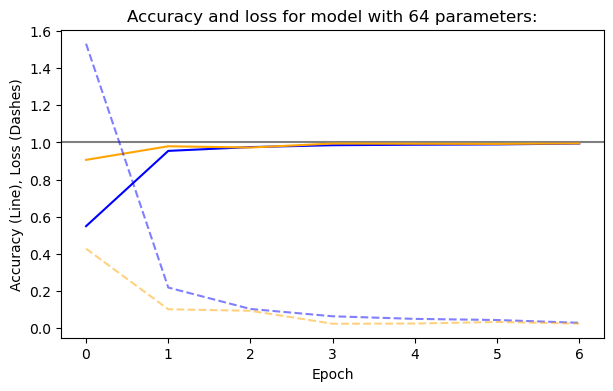

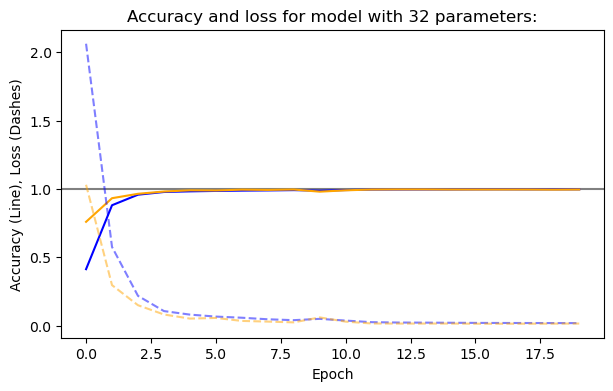

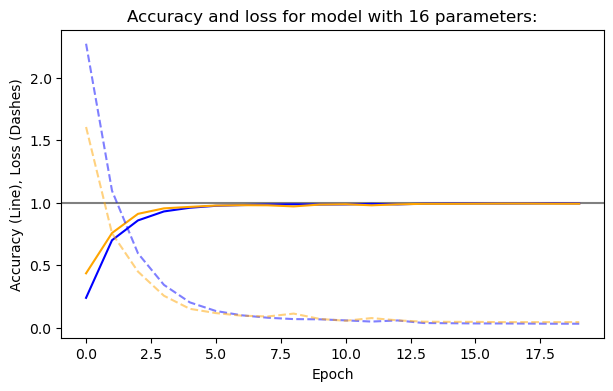

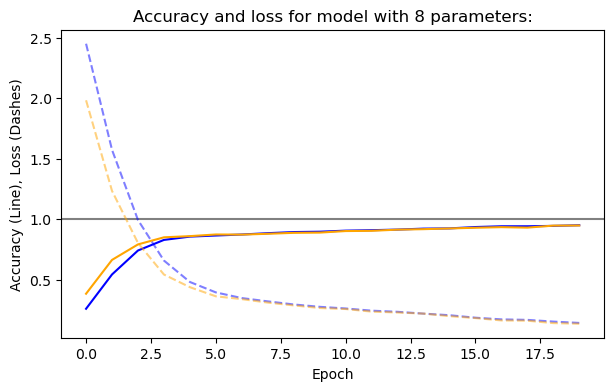

In [12]:
histories = [history_64, history_32, history_16, history_8]

params_count = 64

for history in histories:
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(7, 4))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.title(f"Accuracy and loss for model with {int(params_count)} parameters:")
    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)
    
    params_count /= 2

5/5 [==============================] - 0s 4ms/step
0.140625
5/5 [==============================] - 0s 3ms/step
0.140625
5/5 [==============================] - 0s 2ms/step
0.3125
5/5 [==============================] - 0s 2ms/step
0.109375


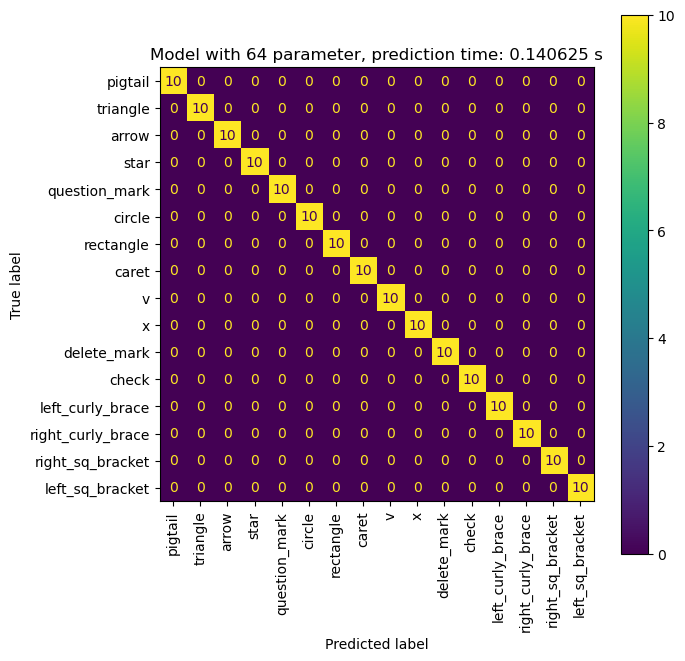

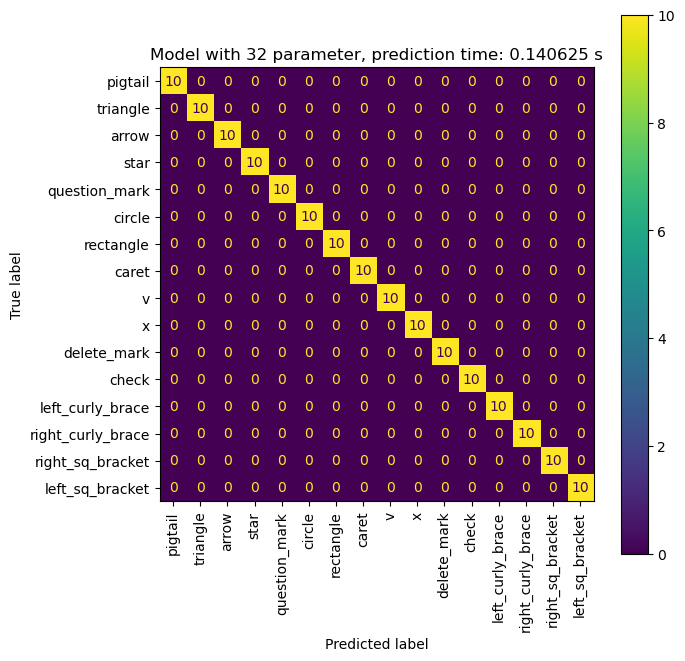

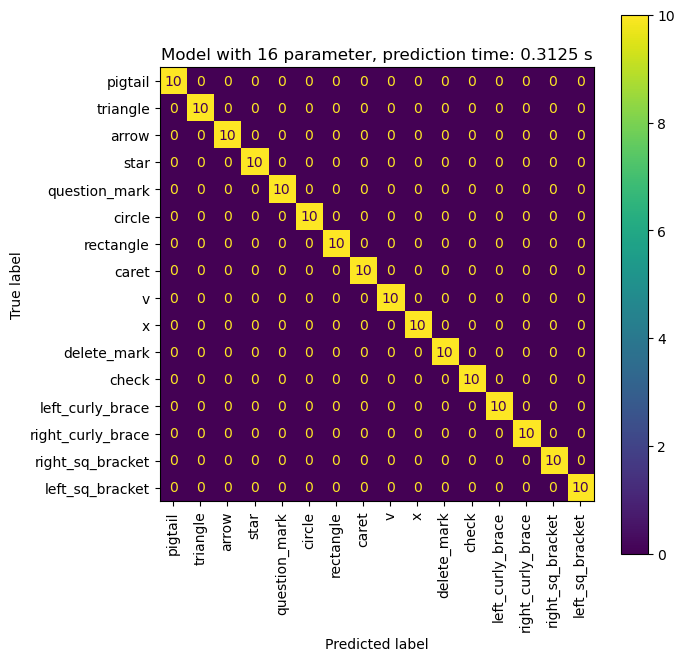

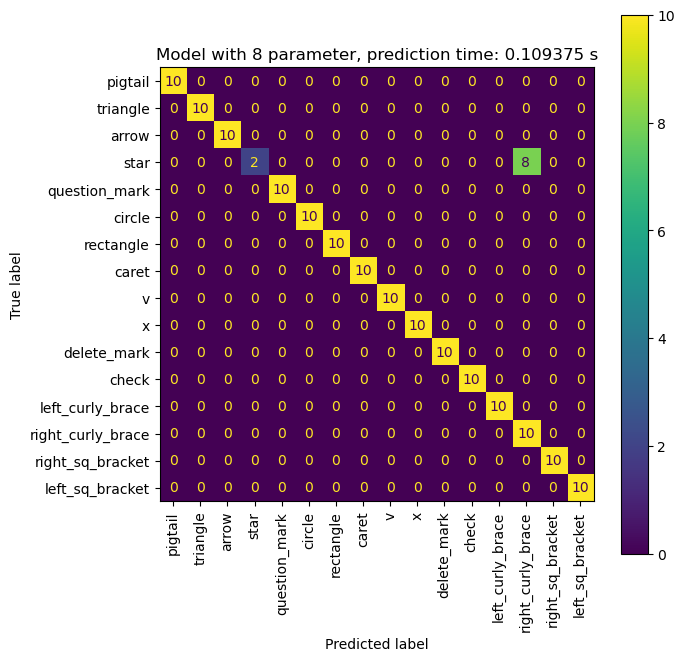

In [13]:
models = [model_64, model_32, model_16, model_8]
params_count = 64

for model in models:
    
    t0 = process_time()
    
    # let the model make predictions for our training data
    y_predictions = model.predict(X_pred_test)
    
    t1 = process_time()
    time_to_predict = t1 - t0
    
    print(time_to_predict)

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_pred_test, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(7, 7))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')
    plt.title(f'Model with {int(params_count)} parameter, prediction time: {time_to_predict} s')
    
    params_count /= 2
    pass

# $1 Recognizer Prediction

In [17]:
dollar_recognizer = recognizer.DollarRecognizer()

X_prediction_data = []

for sample in X_pred_test:
    sample_points = []
    for point in sample:
        sample_points.append(recognizer.Point(point[0], point[1]))
        #print(point)
    
    #print(sample)
    #print("--")
    X_prediction_data.append(sample_points)

In [18]:
y_gesture_predictions = []
time_to_predict_gesture = 0
for gesture in X_prediction_data:
    t0 = process_time()
    result = dollar_recognizer.recognize(gesture)
    t1 = process_time()
    time_to_predict_one = t1 - t0
    time_to_predict_gesture += time_to_predict_one
    y_gesture_predictions.append(result.name)

arrow, -0.2554978394441953, 0:00:00.018564
arrow, -0.2642536297842021, 0:00:00.017004
arrow, -0.251059972653662, 0:00:00.017005
arrow, -0.28724166831228626, 0:00:00.017003
arrow, -0.2858817827850624, 0:00:00.016005
arrow, -0.2618380612472166, 0:00:00.017508
arrow, -0.2793434156432646, 0:00:00.018004
arrow, -0.28079698269901127, 0:00:00.018004
arrow, -0.26792853683535256, 0:00:00.018004
arrow, -0.3026012535708398, 0:00:00.017004
caret, -0.34457112114345845, 0:00:00.017005
caret, -0.31816355216520426, 0:00:00.017507
caret, -0.31610185547840985, 0:00:00.017004
caret, -0.3294330551263099, 0:00:00.017004
caret, -0.27754350728376986, 0:00:00.018085
caret, -0.2657908907322489, 0:00:00.017004
caret, -0.26632371207495403, 0:00:00.017004
caret, -0.27642373258416714, 0:00:00.016508
caret, -0.26488121358605604, 0:00:00.018004
caret, -0.2824576208638849, 0:00:00.017004
check, -0.34021977409909915, 0:00:00.018004
check, -0.36824357307683925, 0:00:00.017004
rectangle, -0.37022098418207583, 0:00:00.01

Text(0.5, 1.0, '$1 Recognizer, prediction time: 1.328125 s')

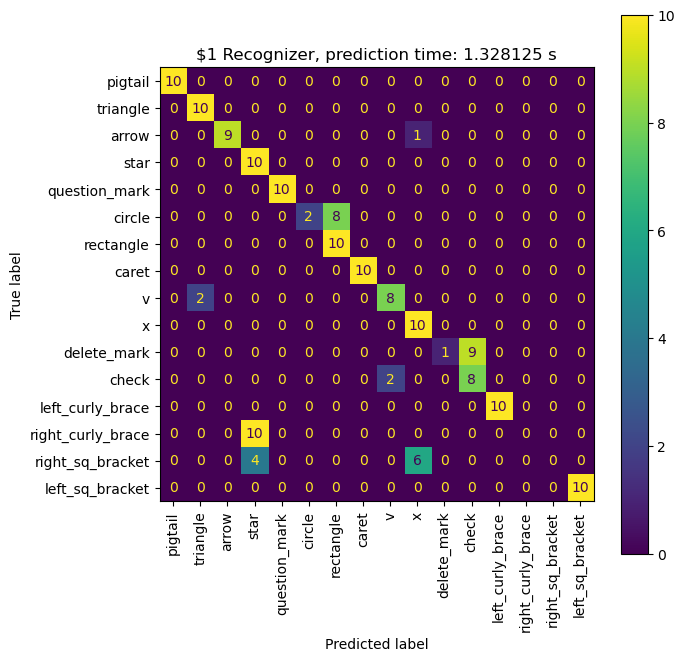

In [19]:
# create and plot confusion matrix
conf_matrix = confusion_matrix(pred_labels, y_gesture_predictions)

fig = plt.figure(figsize=(7, 7))
conf_mat_labels = ['arrow','caret','check','circle','delete_mark','left_curly_brace','left_sq_bracket','pigtail',
                   'question_mark','rectangle','right_curly_brace','right_sq_bracket','star','triangle','v','x']

ConfusionMatrixDisplay(conf_matrix, display_labels=set(conf_mat_labels)).plot(ax=plt.gca())


plt.xticks(rotation=90, ha='center')
plt.title(f'$1 Recognizer, prediction time: {time_to_predict_gesture} s')

# Results

| Parameter count | accuracy | val_accuracy | epochs | prediction time (160 samples) | prediciton mistakes | 
|:---:|:---:| :---:|:---:|:---:|:---:|
| 64 | 0.9941 | 0.9951 | 7 | 0.1406 s  | 0 |
| 32 | 0.9963 | 0.9951 | 20 | 0.1406 s | 0 |
| 16 | 0.9934 | 0.9912 | 20 | 0.3125 s | 0 |
| 8 | 0.9514 | 0.9492 | 20 | 0.1094 s | 8 | 

The best accuracies for the 160 samples were the LSTM with 64 and 32 parameters (both val_accuracies: 0.9951). The 64-parameter-count-one just didn't took as long to train as the 32-one. The less the parameter count is the lower the accuracy gets (model with 8 paramters: only 0.9492 in val_accuracy). Also the less the parameter count is the more mistakes it makes (model with 8 parameters: 8 mistakes). Surprisingly, the prediction time of the model with 8 parameters was faster than the other ones, but as already mentioned with 8 prediction mistakes.

## Comparision with the \$1 Recognizer

The \$1 Gesture Recognizer by Wobbrock et al. was not as good as aspected. In comparision with the LSTM models it took 10 times longer to predict the gestures (1,265625 seconds) and it got confused with a lot of gestures (mistakes made: 42). "Right curly brace" and "v" haven't been recognized correctly at all, "rectangle" and "left curly brace" were also hardly recognized.

The \$1 Recognizer does only take one Unistroke as training (mostly pixel perfect gestures in my case) and it could be that the test samples were just very squiggly (quick handwriting or something). 

But the \$1 Recognizer is easy to implement and doesn't need a ton of training data. So I would recommend this Recognizer for quick recognitions / input applications that won't do something very bad if recognized wrong (like a media player - volume up, volume down, pause/play: these inputs can be redone and corrected quickly).

| Model | prediction mistakes | prediction accuracy |
|:---:|:---:|:---:|
| LSTM_64 | 0 | 1.00 |
| LSTM_32 | 0 | 1.00 |
| LSTM_16 | 0 | 1.00 |
| LSTM_8 | 8 | 0.95 |
| $1 Recognizer | 42 | 0.74 |